In [1]:
# imports
import sys, os
sys.path.append(os.getcwd()+'/code')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import Algorithms
from data_streamer import Streamer, MultiStreamer

In [2]:
# constants
train_data_file=[os.getcwd() + '/data/synth_data_bach_jordan_train_view1.csv',
                 os.getcwd() + '/data/synth_data_bach_jordan_train_view2.csv']
validation_data_file=[os.getcwd() + '/data/synth_data_bach_jordan_test_view1.csv',
                      os.getcwd() + '/data/synth_data_bach_jordan_test_view2.csv']
assert os.path.isfile(train_data_file[0])
assert os.path.isfile(train_data_file[1])
assert os.path.isfile(validation_data_file[0])
assert os.path.isfile(validation_data_file[1])
k = 5 # dimensionality of representations
dx, dy = 11, 21 # dimensionality of input
learning_rate = 1e-3 # initial learning rate
validation_freq = 2**13 # how many training steps in between validations

In [3]:
# util functions to compute best CCA loss
def inv_sqrt(x):
    # inverse squareroot of symmetric matrix
    values,vectors=np.linalg.eigh(x)
    out=np.dot(vectors,np.diag(np.reciprocal(np.sqrt(values))))
    out=np.dot(out,vectors.T)
    return out

def matrix_product(array):
    # return the product of the matrices in the array
    assert len(array)>1
    out=np.dot(array[0],array[1])
    for x in array[2:]:
        out=np.dot(out,x)
    return out

def max_loss(training_batch):
    H=np.concatenate(training_batch,axis=1)
    # covariance matrices
    mu=np.mean(H,axis=0,keepdims=True)
    centered_h=H-mu
    # covariance matrix
    X,Y=training_batch
    centered_x=X-np.mean(X,axis=0,keepdims=True)
    centered_y=Y-np.mean(Y,axis=0,keepdims=True)
    C=np.dot(centered_x.T,centered_y)
    _,D,_=np.linalg.svd(C)
    loss=sum(D[:k])
    return loss

In [4]:
# data streamer and algorithm
train_stream = MultiStreamer(train_data_file).get_stream()
algorithm=Algorithms.msg_cca({'dx': dx, 'dy': dy, 'k': k, 'learning_rate': learning_rate, 'mean_center': 0.})
# load validation data at once to make validation faster
validation_data=[[],[]]
for point in MultiStreamer(validation_data_file).get_stream():
    x,y=point
    validation_data[0].append(x)
    validation_data[1].append(y)
validation_data[0]=np.stack(validation_data[0],axis=0)
validation_data[1]=np.stack(validation_data[1],axis=0)
max_loss_validation=max_loss(validation_data)/(validation_data[0].shape[0]*k)
# load training data
training_data=[[],[]]
for point in MultiStreamer(train_data_file).get_stream():
    x,y=point
    if len(training_data[0])==len(validation_data[0]):
        break
    training_data[0].append(x)
    training_data[1].append(y)
training_data[0]=np.stack(training_data[0],axis=0)
training_data[1]=np.stack(training_data[1],axis=0)

In [5]:
# placeholders for loss
validation_loss, training_loss, max_training_loss = [], [], []
# main loop
counter=0
for point in train_stream:
    counter+=1
    algorithm.step(point)
    if counter%validation_freq==0:
        print(counter)
        loss=algorithm.loss(validation_data)
        loss/=(validation_data[0].shape[0]*k)
        validation_loss.append(loss)
        loss=algorithm.loss(training_data)
        loss/=(training_data[0].shape[0]*k)
        training_loss.append(loss)

8192
16384
24576
32768
40960
49152
57344
65536
73728
81920
90112
98304
106496
114688
122880
131072
139264
147456
155648
163840
172032
180224
188416
196608
204800
212992
221184
229376
237568
245760
253952
262144
270336
278528
286720
294912
303104
311296
319488
327680
335872
344064
352256
360448
368640
376832
385024
393216
401408
409600
417792
425984
434176
442368
450560
458752
466944
475136
483328
491520
499712
507904
516096
524288
532480
540672
548864
557056
565248
573440
581632
589824
598016
606208
614400
622592
630784
638976
647168
655360
663552
671744
679936
688128
696320
704512
712704
720896
729088
737280
745472
753664
761856
770048
778240
786432
794624
802816
811008
819200
827392
835584
843776
851968
860160
868352
876544
884736
892928
901120
909312
917504
925696
933888
942080
950272
958464
966656
974848
983040
991232
999424
1007616
1015808
1024000
1032192


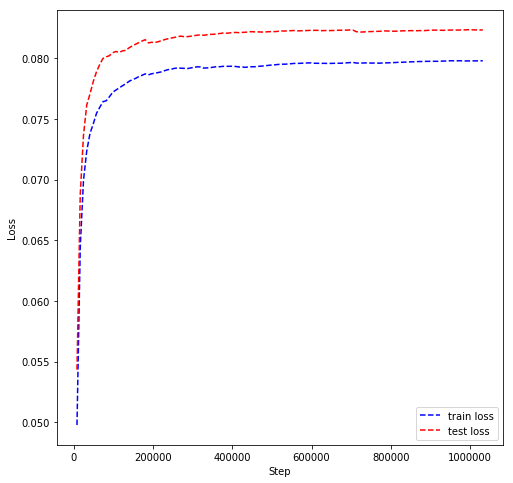

In [8]:
# plot the train and test loss
plt.figure(figsize=(8, 8))
plt.xlabel('Step')
plt.ylabel('Loss')
x_scale=[x*validation_freq for x in range(1,len(training_loss)+1)]
plt.plot(x_scale, training_loss, '--b', label='train loss')
plt.plot(x_scale, validation_loss, '--r', label='test loss')
#plt.plot(x_scale, [max_loss_validation]*len(training_loss), '--k', label='train loss upper bound')
_ = plt.legend()